## 0 - Introduction

Welcome to the <span style="color:yellowgreen">Foundations of Machine Learning</span> (ECE5984_41) course!

This is the <span style="color:red">2nd</span> lab practice. From now on, you will going to implement logistic regression and L2 regularization. 

### Outline
- [ 1 - Packages ](#1-packages)
- [ 2 - Problem Statement and Dataset ](#2-problem-statement-and-dataset)
- [ 3 - Logistic Regression ](#3-logistic-regression)
  - [ 3.1 Sigmoid function ](#31-sigmoid-function) - Exercise 1
  - [ 3.2 Binary Cross Entropy Loss](#32-binary-cross-entropy-loss) - Exercise 2
  - [ 3.3 Gradient Descent ](#33-gradient-descent) - Exercise 3, Exercise 4
- [ 4 - L2 Regularization ](#4-l2-regularization) - Exercise 5

## 1. Packages 

You have to install and use below packages for HW#2.
- [numpy](https://www.numpy.org): Fundamental package for matrix computation with python.
- [matplotlib](https://matplotlib.org): Package for visualization of the graph with python.
- [pandas](https://pandas.pydata.org): Open source package for data analysis and manipulation.

**Do not use other machine learning packages in this homework, e.g., *tensorflow*, *pytorch*, *jax*, etc.**

In [2]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## 2. Problem Statement and Dataset

### Problem Statement

[Fake Bills Dataset](https://www.kaggle.com/code/unmoved/classify-fake-bills)

The *Fake Bills Dataset* consists 
The dataset consists 1500 samples of bills. Some of the bills are real, and some are fake.

In this homework, we would like to fit the logistic regression model on this dataset to determine if the given bill is fake or real!

### Dataset

You will start by loading the dataset. Make sure the attached 'fake_bills.csv' file is in your current directory(can be downloaded from icampus).

Each column describes the below attributes:
- \[ is_genuine \]: if the given bill is real or not.
- \[ diagonal \]: the diagonal of the banknote in mm.
- \[ height_left \]: the height of the left side of the banknote in mm.
- \[ height_right \]: the height of the right side of the banknote in mm.
- \[ margin_low \]: lower side margin of the banknote in mm.
- \[ margin_up \]: upper side margin of the banknote in mm.
- \[ length \]: the length of the banknote in mm.

Run below cells and take a look of the dataset!

In [3]:
# Load the dataset
dataset = pd.read_csv("./fake_bills.csv")

# Display top 5 elements
dataset.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
# check dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In this lab practice, we will not going to use "margin_low" and "margin_up" features. 

(There are some missing-value cells on those attributes. We can use mean value or apply knn algorithm to fill in those cells, but in this lab practice, let's just simply drop those attributes.)

In [5]:
dataset.drop(labels=['margin_low', 'margin_up'], axis=1, inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   length        1500 non-null   float64
dtypes: bool(1), float64(4)
memory usage: 48.5 KB


In [6]:
# Seperate train data and label from the dataset.
data = dataset.drop(labels=['is_genuine'], axis=1, inplace=False).to_numpy()
label = dataset["is_genuine"].to_numpy()
label = label.astype(float)

# Check data statistics
print("The shape of data is", data.shape)
print("The shape of label is", label.shape)
print()

print("The first Five elements of data are", data[:5])
print("The first Five elements of label are", label[:5])
print()

The shape of data is (1500, 4)
The shape of label is (1500,)

The first Five elements of data are [[171.81 104.86 104.95 112.83]
 [171.46 103.36 103.66 113.09]
 [172.69 104.48 103.5  113.16]
 [171.36 103.91 103.94 113.51]
 [171.73 104.28 103.46 112.54]]
The first Five elements of label are [1. 1. 1. 1. 1.]



Normalizing data equalizes the scale of each features, which encourages fast and stable convergence for gradient descent. 

Run below code and normalize your data!

In [7]:
# Normalize the data
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
print("The first Five elements of data are", data[:5])

The first Five elements of data are [[-0.48653957  2.77412327  3.16324041  0.17365114]
 [-1.63372936 -2.23653528 -0.79966777  0.47166629]
 [ 2.3978233   1.50475644 -1.29119126  0.55190114]
 [-1.96149786 -0.39929381  0.06049835  0.95307539]
 [-0.74875438  0.83666863 -1.41407214 -0.15875038]]


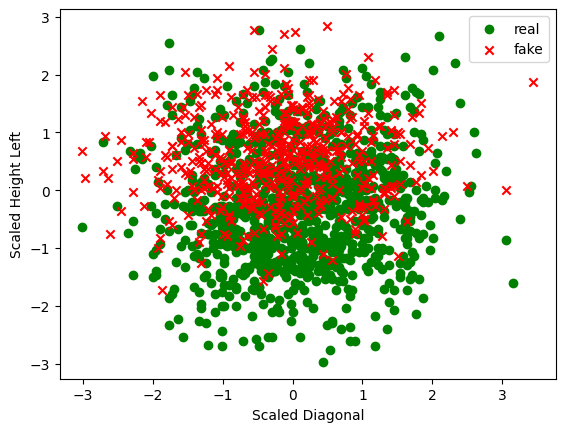

In [8]:
# Visualize two features (1st & 2nd dimension of the feature)
real = (label == 1)
fake = (label == 0)

plt.scatter(data[real, 0], data[real, 1], marker='o', c='g', label="real")
plt.scatter(data[fake, 0], data[fake, 1], marker='x', c='r', label="fake")
plt.xlabel("Scaled Diagonal")
plt.ylabel("Scaled Height Left")
plt.legend()
plt.show()

## 3. Logistic Regression

### 3.1 Sigmoid Function

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

\> In Exercise 1, you will implement the logistic function, i.e., sigmoid function. Below <span style="color:skyblue">sigmoid()</span> returns sigmoid function value of given input x.

Do not change the method name and its argument.

### <span style="color:#ffd33d"> Exercise 1 </span>: Write the code for sigmoid function

In [9]:
# Complete the code for sigmoid function
def sigmoid(x):
    """
    compute the sigmoid of x.
    
    Args:
        x    (np.ndarray): Shape (N, )
    
    Return:
        sigma    (np.ndarray): Shape (N, ) Sigmoid values of given input x
    """
    sigma = 1.0 / (1.0 + np.exp(-x))
    return sigma

x = np.array([-1, 0, 1])
sigmoid(x)

array([0.26894142, 0.5       , 0.73105858])

Test Sigmoid Implementation

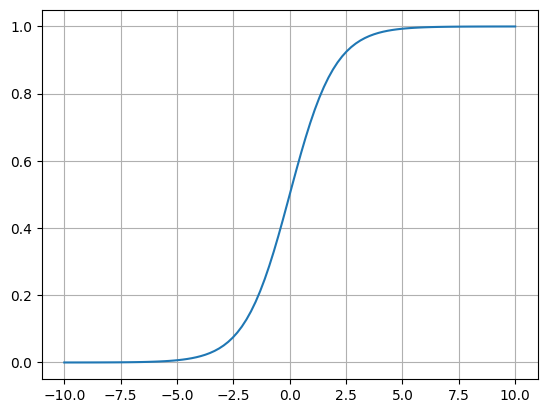

In [10]:
x = np.linspace(-10, 10, 100)
y = sigmoid(x)
plt.plot(x, y)
plt.grid()

### 3.2 Binary Cross-Entropy Loss

$$\hat{y}^{(i)} = \sigma(w^T x^{(i)} + b)$$

$$BCE(w, b) = - \sum_{i=1}^{N} y^{(i)} \cdot log(\hat{y}^{(i)}) + (1-y^{(i)}) \cdot log(1-\hat{y}^{(i)})$$

* N is the number of training examples in the dataset

### <span style="color:#ffd33d"> Exercise 2 </span>: Complete the code for BCELoss

\> Here, the <span style="color:skyblue">compute_bceloss()</span> method computes the binary cross-entropy loss of the logistic regression model. 

Feel free to change or add variables, but do not modify the method name and its arguements.

In [11]:
def compute_bceloss(data, label, w, b):
    """
    Compute the bceloss of the logistic regression model, given data and label.

    Args:
        data    (np.ndarray): Shape (N, M) Input to the model
        label   (np.ndarray): Shape (N, ) Label of the data
        w       (np.ndarray): Weight of the logistic regression model
        b       (float): Bias of the logistic regression model
    
    Return:
        total_loss (float): Total bceloss of the logistic regression model, given data and label
    """
    total_loss = 0

    #[NOTE] write your code here!
    # Note: 
    # using * operator in numpy which is element-wise multiplication
    # using @ operator in numpy which is matrix multiplication
    pre_estimated_label = data @ w + b 
    estimated_lable = sigmoid(pre_estimated_label)

    y = label; y_hat = estimated_lable

    total_loss = -np.sum((y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))
    return total_loss

w = np.zeros(4)
b = 0.0

compute_bceloss(data, label, w, b)

1039.720770839918

### 3.3 Gradient Descent

$$
\frac{\partial BCE(\mathbf{w},b)}{\partial w_j}  = \sum\limits_{i = 1}^{N} (\hat{y}^{(i)} - {y}^{(i)})x_{j}^{(i)}
$$
$$
\frac{\partial BCE(\mathbf{w},b)}{\partial b}  = \sum\limits_{i = 1}^{N} (\hat{y}^{(i)} - {y}^{(i)})
$$
* N is the number of training examples in the dataset

### <span style="color:#ffd33d"> Exercise 3 </span>: Complete the code for computing the gradient of the loss w.r.t weights and bias

\> Here, the <span style="color:skyblue">compute_gradient()</span> method computes the gradient of the loss with respect to the parameters of the logistic regression model.

Feel free to change or add variables, but do not modify the method name and its arguments.

In [12]:
def computeMyMatrix(y, y_hat):
    """
    Compute my_matrix such that
        grad(BCE Loss) = my_matrix @ [data 1]

    Args:
        pre_estimated_label (np.ndarray): Shape (N, ) Output of linear regression model
        label   (np.ndarray): Shape (N, ) Label of the data
        w       (np.ndarray): Weight of the logistic regression model
        b       (float): Bias of the logistic regression model
    
    Return:
       my_matrix  (np.ndarray): Shape (N, )
    """
    my_matrix = -y_hat * (1 - y_hat) * (y/y_hat - (1 - y)/ (1-y_hat))
    return my_matrix

def compute_gradient(data, label, w, b):
    """
    Compute the gradient of the loss w.r.t weight & bias of model, given data and label.

    Args:
        data    (np.ndarray): Shape (N, ) Input to the model
        label   (np.ndarray): Shape (N, ) Label of the data
        w       (np.ndarray): Weight of the logistic regression model
        b       (float): Bias of the logistic regression model
    
    Return:
       grad_w   (np.ndarray): The gradient of the loss w.r.t weight w
       grad_b   (float): The gradient of the loss w.r.t bias b
    """
    grad_w, grad_b = 0, 0

    #[NOTE] write your code here!
    # X = [data 1]; 1 which means columns of 1 
    pre_estimated_label = data @ w + b 
    estimated_lable = sigmoid(pre_estimated_label)
    y = label; y_hat = estimated_lable

    N = data.shape[0]
    X = np.hstack([data, np.ones([N, 1])])
    my_matrix = computeMyMatrix(y, y_hat)
    
    grad_bce = my_matrix @ X 
    grad_w = grad_bce[0:-1]; grad_b = grad_bce[-1]
    return grad_w, grad_b

compute_gradient(data, label, w, b)

(array([ -93.87290093,  268.58243322,  343.0117191 , -600.53492456]), -250.0)

### <span style="color:#ffd33d"> Exercise 4 </span>: Complete the code of gradient descent algorithm

\> <span style="color:skyblue">gradient_descent()</span> method applies gradient descent on logistic regression model on the given dataset. You should make 'loop' inside this method to iteratively update w and b. You __**must**__ use <span style="color:skyblue">compute_bceloss()</span> and <span style="color:skyblue">compute_gradient()</span> method to calculate bceloss and gradients, respectively.

Also, for the purpose of visualization of the training curve, this method returns some 'history' lists. You can just simply append updated values to the corresponding 'history' list.

Feel free to change or add variables, but do not modify the method name, its arguments, and return values.

In [13]:
def gradient_descent(data, label, w_init, b_init, iters=1500, lr=0.0001):
    """
    Performs batch gradient descent to obatain weight and bias of the logistic regression model.
    
    Args:
      data    (np.ndarray): Shape (N,)
      label   (np.ndarray): Shape (N,)
      w_init  (np.ndarray): Initial value of weight of the model
      b_init  (float): Initial values of bias of the model
      lr      (float): Learning rate
      iters   (int): Number of iterations to run gradient descent
    Returns
      w             (np.ndarray): Weight of the logistic regression model obtained with BGD
      b             (float): Bias of the logistic regression model obtained with BGD
      loss_history  (list): loss values of every iteration steps
      w_history     (list): w values of every iteration steps
      b_history     (list): b values of every iteration steps
    """
    loss_history = []
    w_history = []
    b_history = []
    w = w_init
    b = b_init

    for i in range(iters):
        #[NOTE] write your code here!
        loss = compute_bceloss(data, label, w, b)
        grad_w, grad_b = compute_gradient(data, label, w, b)

        w = w - lr * grad_w
        b = b - lr * grad_b

        loss_history.append(loss)
        w_history.append(w)
        b_history.append(b)
        # print loss for every 100 iterations
        if i % 100 == 99:
            print(f"[ {i + 1:4}/{iters} ] BCELoss: {loss:.4f}")
    
    return w, b, loss_history, w_history, b_history

Now apply your gradient descent algorithm!

In [14]:
# initial values of w and b
w_init, b_init = np.random.randn(4), .0

# hyperparameters for gradient descent algorithm
iters = 1500
learning_rate = 0.0001

# obtain w and b with gradient descent
w, b, loss_history, w_history, b_history = gradient_descent(
                                                data, label, w_init, b_init,
                                                iters=iters,
                                                lr=learning_rate,
                                            )

print("w,b found by gradient descent:", w, b)


[  100/1500 ] BCELoss: 262.9137
[  200/1500 ] BCELoss: 198.0165
[  300/1500 ] BCELoss: 175.9688
[  400/1500 ] BCELoss: 164.8465
[  500/1500 ] BCELoss: 158.1878
[  600/1500 ] BCELoss: 153.7957
[  700/1500 ] BCELoss: 150.7115
[  800/1500 ] BCELoss: 148.4490
[  900/1500 ] BCELoss: 146.7347
[ 1000/1500 ] BCELoss: 145.4031
[ 1100/1500 ] BCELoss: 144.3482
[ 1200/1500 ] BCELoss: 143.4991
[ 1300/1500 ] BCELoss: 142.8065
[ 1400/1500 ] BCELoss: 142.2353
[ 1500/1500 ] BCELoss: 141.7598
w,b found by gradient descent: [ 0.46652879 -0.78942119 -1.16166358  4.69520189] 1.5995181071904732


Plot training curve!

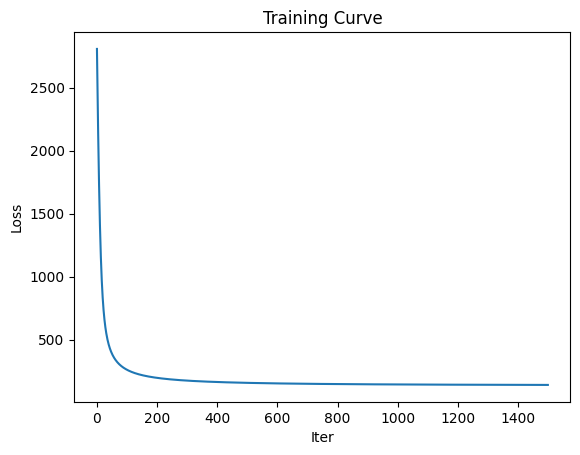

In [15]:
loss_history = loss_history

# plot training curve
plt.plot(range(len(loss_history)), loss_history)
plt.title("Training Curve")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.show()

Plot decision boundary of your logistic regression model!

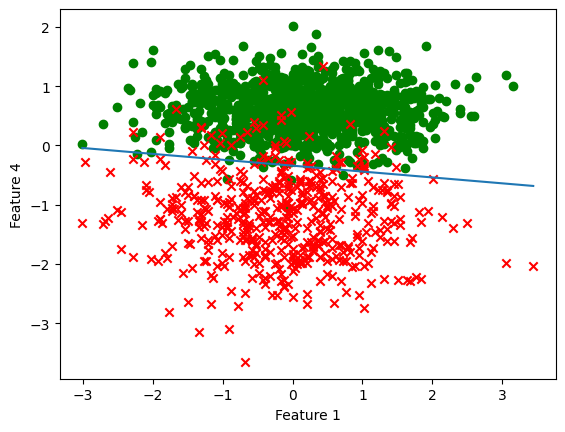

In [16]:
def plot_decision_boundary(data, label, w, b, feature_dims=(0, 1)):
    # scatter data along the feature_dims
    dim_1, dim_2 = feature_dims

    real = (label == 1)
    fake = (label == 0)

    plt.scatter(data[real, dim_1], data[real, dim_2], marker='o', c='g', label="real")
    plt.scatter(data[fake, dim_1], data[fake, dim_2], marker='x', c='r', label="fake")
    plt.xlabel(f'Feature {dim_1 + 1}')
    plt.ylabel(f'Feature {dim_2 + 1}')

    db_x = np.array([min(data[:, dim_1]), max(data[:, dim_1])])
    db_y = ((-1. / w[dim_2]) * (w[dim_1] * db_x + b))

    plt.plot(db_x, db_y)

# feel free to change 'feature_dims' argument to the other feature dimension indices,
#   and check if your model fits well on the dataset!
plot_decision_boundary(data, label, w, b, feature_dims=(0, 3))

## 4. L2 Regularization

$$\hat{y}^{(i)} = \sigma(w^T x^{(i)} + b)$$

$$BCE(w, b) = - \sum_{i=1}^{N} y^{(i)} \cdot log(\hat{y}^{(i)}) + (1-y^{(i)}) \cdot log(1-\hat{y}^{(i)})$$

$$L(w, b) = BCE(w, b) + \frac{\lambda}{2} \| w\|^2$$

### <span style="color:#ffd33d"> Exercise 5 </span>: Complete the below codes

\> Here, the <span style="color:skyblue">compute_l2_reg_loss()</span> method computes the l2 regularized loss of the logistic regression model.

Feel free to change or add variables, but do not modify the method name and its arguements.

In [17]:
def compute_l2_reg_loss(data, label, w, b, l2_lambda=0.5):
    """
    Compute the bceloss of the logistic regression model, given data and label.

    Args:
        data    (np.ndarray): Shape (N, ) Input to the model
        label   (np.ndarray): Shape (N, ) Label of the data
        w       (np.ndarray): Weight of the logistic regression model
        b       (float): Bias of the logistic regression model
    
    Return:
        total_loss (float): Total bceloss of the logistic regression model with l2 regularization, given data and label
    """
    total_loss = 0

    #[NOTE] write your code here!
    BCE_loss = compute_bceloss(data, label, w, b) 
    total_loss = BCE_loss + 0.5 * l2_lambda * np.square(np.linalg.norm(w))  

    return total_loss



In [18]:
def computeMyMatrix(y, y_hat):
    """
    Compute my_matrix such that
        grad(BCE Loss) = my_matrix @ [data 1]

    Args:
        pre_estimated_label (np.ndarray): Shape (N, ) Output of linear regression model
        label   (np.ndarray): Shape (N, ) Label of the data
        w       (np.ndarray): Weight of the logistic regression model
        b       (float): Bias of the logistic regression model
    
    Return:
       my_matrix  (np.ndarray): Shape (N, )
    """
    my_matrix = -y_hat * (1 - y_hat) * (y/y_hat - (1 - y)/ (1-y_hat))
    return my_matrix

def compute_gradient(data, label, w, b):
    """
    Compute the gradient of the loss w.r.t weight & bias of model, given data and label.

    Args:
        data    (np.ndarray): Shape (N, ) Input to the model
        label   (np.ndarray): Shape (N, ) Label of the data
        w       (np.ndarray): Weight of the logistic regression model
        b       (float): Bias of the logistic regression model
    
    Return:
       grad_w   (np.ndarray): The gradient of the loss w.r.t weight w
       grad_b   (float): The gradient of the loss w.r.t bias b
    """
    grad_w, grad_b = 0, 0

    #[NOTE] write your code here!
    # X = [data 1]; 1 which means columns of 1 
    pre_estimated_label = data @ w + b 
    estimated_lable = sigmoid(pre_estimated_label)
    y = label; y_hat = estimated_lable

    N = data.shape[0]
    X = np.hstack([data, np.ones([N, 1])])
    my_matrix = computeMyMatrix(y, y_hat)
    
    grad_bce = my_matrix @ X 
    grad_w = grad_bce[0:-1]; grad_b = grad_bce[-1]
    return grad_w, grad_b

def compute_l2_gradient(data, label, w, b, l2_lambda):
    """
    Compute the gradient of the loss w.r.t weight & bias of model, given data and label.

    Args:
        data    (np.ndarray): Shape (N, ) Input to the model
        label   (np.ndarray): Shape (N, ) Label of the data
        w       (np.ndarray): Weight of the logistic regression model
        b       (float): Bias of the logistic regression model
    
    Return:
       grad_w   (np.ndarray): The gradient of the loss w.r.t weight w
       grad_b   (float): The gradient of the loss w.r.t bias b
    """
    grad_w, grad_b = 0, 0

    #[NOTE] write your code here!
    grad_w, grad_b = compute_gradient(data, label, w, b)
    grad_w = grad_w + l2_lambda * w
    return grad_w, grad_b



In [19]:
def gradient_descent(data, label, w_init, b_init, iters=1500, lr=0.0001, l2_lambda=0.1):
    """
    Performs batch gradient descent to obatain weight and bias of the logistic regression model.
    
    Args:
      data    (np.ndarray): Shape (N,)
      label   (np.ndarray): Shape (N,)
      w_init  (np.ndarray): Initial value of weight of the model
      b_init  (float): Initial values of bias of the model
      lr      (float): Learning rate
      iters   (int): Number of iterations to run gradient descent
    Returns
      w             (np.ndarray): Weight of the logistic regression model obtained with BGD
      b             (float): Bias of the logistic regression model obtained with BGD
      loss_history  (list): loss values of every iteration steps
      w_history     (list): w values of every iteration steps
      b_history     (list): b values of every iteration steps
    """
    loss_history = []
    w_history = []
    b_history = []
    w = w_init
    b = b_init

    for i in range(iters):
        #[NOTE] write your code here!
        loss = compute_l2_reg_loss(data, label, w, b, l2_lambda)
        grad_w, grad_b = compute_l2_gradient(data, label, w, b, l2_lambda)

        w = w - lr * grad_w
        b = b - lr * grad_b

        loss_history.append(loss)
        w_history.append(w)
        b_history.append(b)
        # print loss for every 100 iterations
        if i % 100 == 99:
            print(f"[ {i + 1:4}/{iters} ] BCELoss: {loss:.4f}")
    
    return w, b, loss_history, w_history, b_history

In [20]:
# initial values of w and b
w_init, b_init = np.zeros(4), .0

# hyperparameters for gradient descent algorithm
iters = 1500
learning_rate = 0.0001
l2_lambda = 0.2

# obtain w and b with gradient descent
w, b, loss_history, w_history, b_history = gradient_descent(
                                                data, label, w_init, b_init,
                                                iters=iters,
                                                lr=learning_rate,
                                                l2_lambda=l2_lambda
                                            )

print("w,b found by gradient descent:", w, b)

[  100/1500 ] BCELoss: 246.5291
[  200/1500 ] BCELoss: 194.4039
[  300/1500 ] BCELoss: 175.1507
[  400/1500 ] BCELoss: 165.1897
[  500/1500 ] BCELoss: 159.1717
[  600/1500 ] BCELoss: 155.1939
[  700/1500 ] BCELoss: 152.4051
[  800/1500 ] BCELoss: 150.3672
[  900/1500 ] BCELoss: 148.8315
[ 1000/1500 ] BCELoss: 147.6462
[ 1100/1500 ] BCELoss: 146.7142
[ 1200/1500 ] BCELoss: 145.9698
[ 1300/1500 ] BCELoss: 145.3679
[ 1400/1500 ] BCELoss: 144.8759
[ 1500/1500 ] BCELoss: 144.4700
w,b found by gradient descent: [ 0.46210499 -0.78398103 -1.1531133   4.64748959] 1.5936394922538273


Plot training_curve!

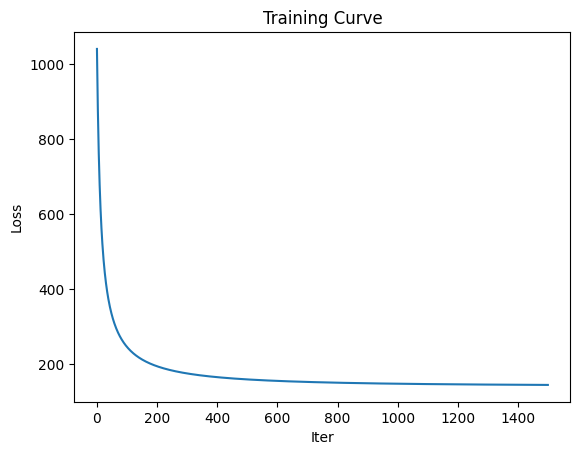

In [21]:
loss_history = loss_history

# plot training curve
plt.plot(range(len(loss_history)), loss_history)
plt.title("Training Curve")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.show()

Plot decision boundary of your logistic regression model, trained with l2 regularized BCE loss!

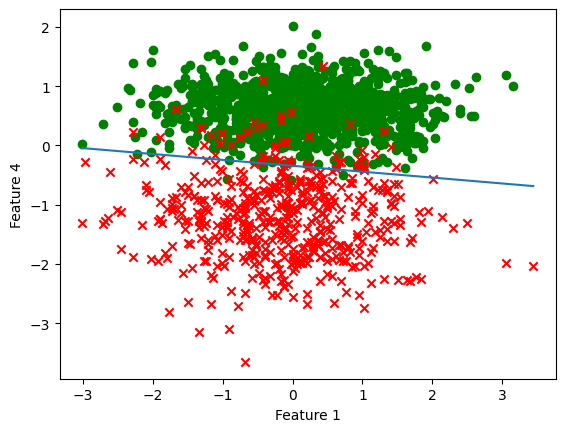

In [22]:
# feel free to change 'feature_dims' argument to the other feature dimension indices,
#   and check if your model fits well on the dataset!
plot_decision_boundary(data, label, w, b, feature_dims=(0, 3))